Resources:

* https://github.com/marcellusruben/medium-resources/blob/main/Layout_Parser/layout_parser_ex.ipynb

* https://colab.research.google.com/github/RajkumarGalaxy/ComputerVision/blob/master/LayoutParser_table_OCR.ipynb#scrollTo=ZsxUTTNpBCQ5

* https://github.com/Layout-Parser/layout-parser/blob/main/examples/Deep%20Layout%20Parsing.ipynb

* https://www.youtube.com/watch?v=YG0qepPgyGY&t=1s&ab_channel=ShannonShen

# Setup

Install dependencies.

In [ ]:
!pip install google-cloud-vision==2.0.0

In [ ]:
!pip install --ignore-installed Pillow==9.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%bash
pip install -U layoutparser
pip install torchvision
pip install "git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
pip install layoutparser[ocr]

# Install tesseract
sudo apt-get update --fix-missing
sudo apt-get install tesseract-ocr
sudo apt-get install libtesseract-dev
sudo apt-get install tesseract-ocr-tur # Turkish language extension

sudo apt-get install poppler-utils

Import libraries.

In [3]:
# TODO: For PDF-Image conversion
# from PIL import Image
# from pdf2image import convert_from_path

# For layout detection
import layoutparser as lp
import cv2

# For processing data
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Demo

## Get Image

Sample data stored in a drive folder.

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

%cd /content/drive/MyDrive/ornek-seffaflik-raporlari
!ls

/content/drive/MyDrive/ornek-seffaflik-raporlari
A1_2013_PDF.pdf  A1_2013_PDF.pdf_006.jpg  AKADEMIK_2016_SCAN.pdf


Read sample image.

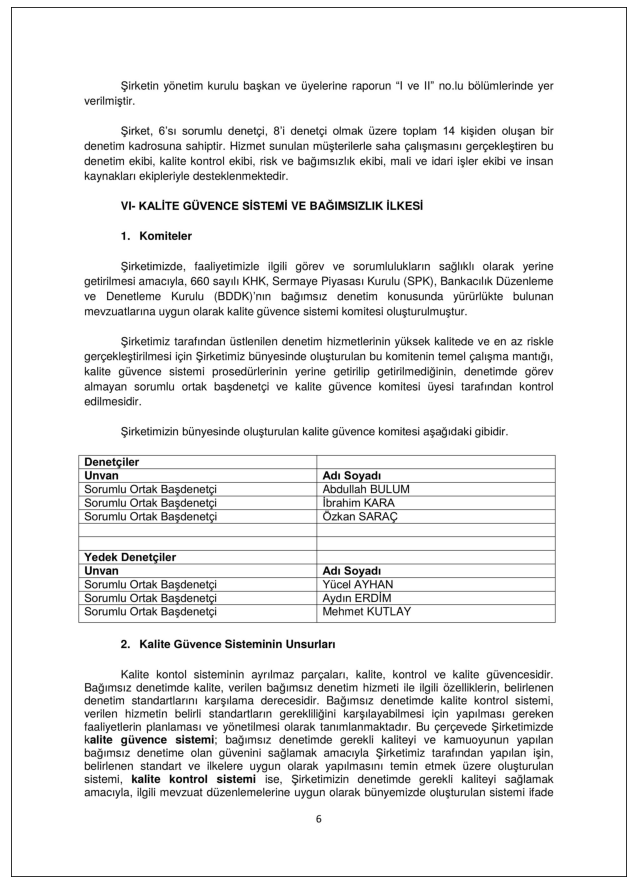

In [5]:
image = cv2.imread("A1_2013_PDF.pdf_006.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert the image from BGR (cv2 default loading style) to RGB

# Display image
plt.figure(figsize=(12,16))
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

## Detect layout.

In [6]:
# Load the deep layout model from the layoutparser API
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})


config.yml?dl=1: 8.19kB [00:01, 5.72kB/s]
model_final.pth?dl=1: 330MB [00:04, 70.0MB/s]                          
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [7]:
layout = model.detect(image) # Detect the layout of the input image

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


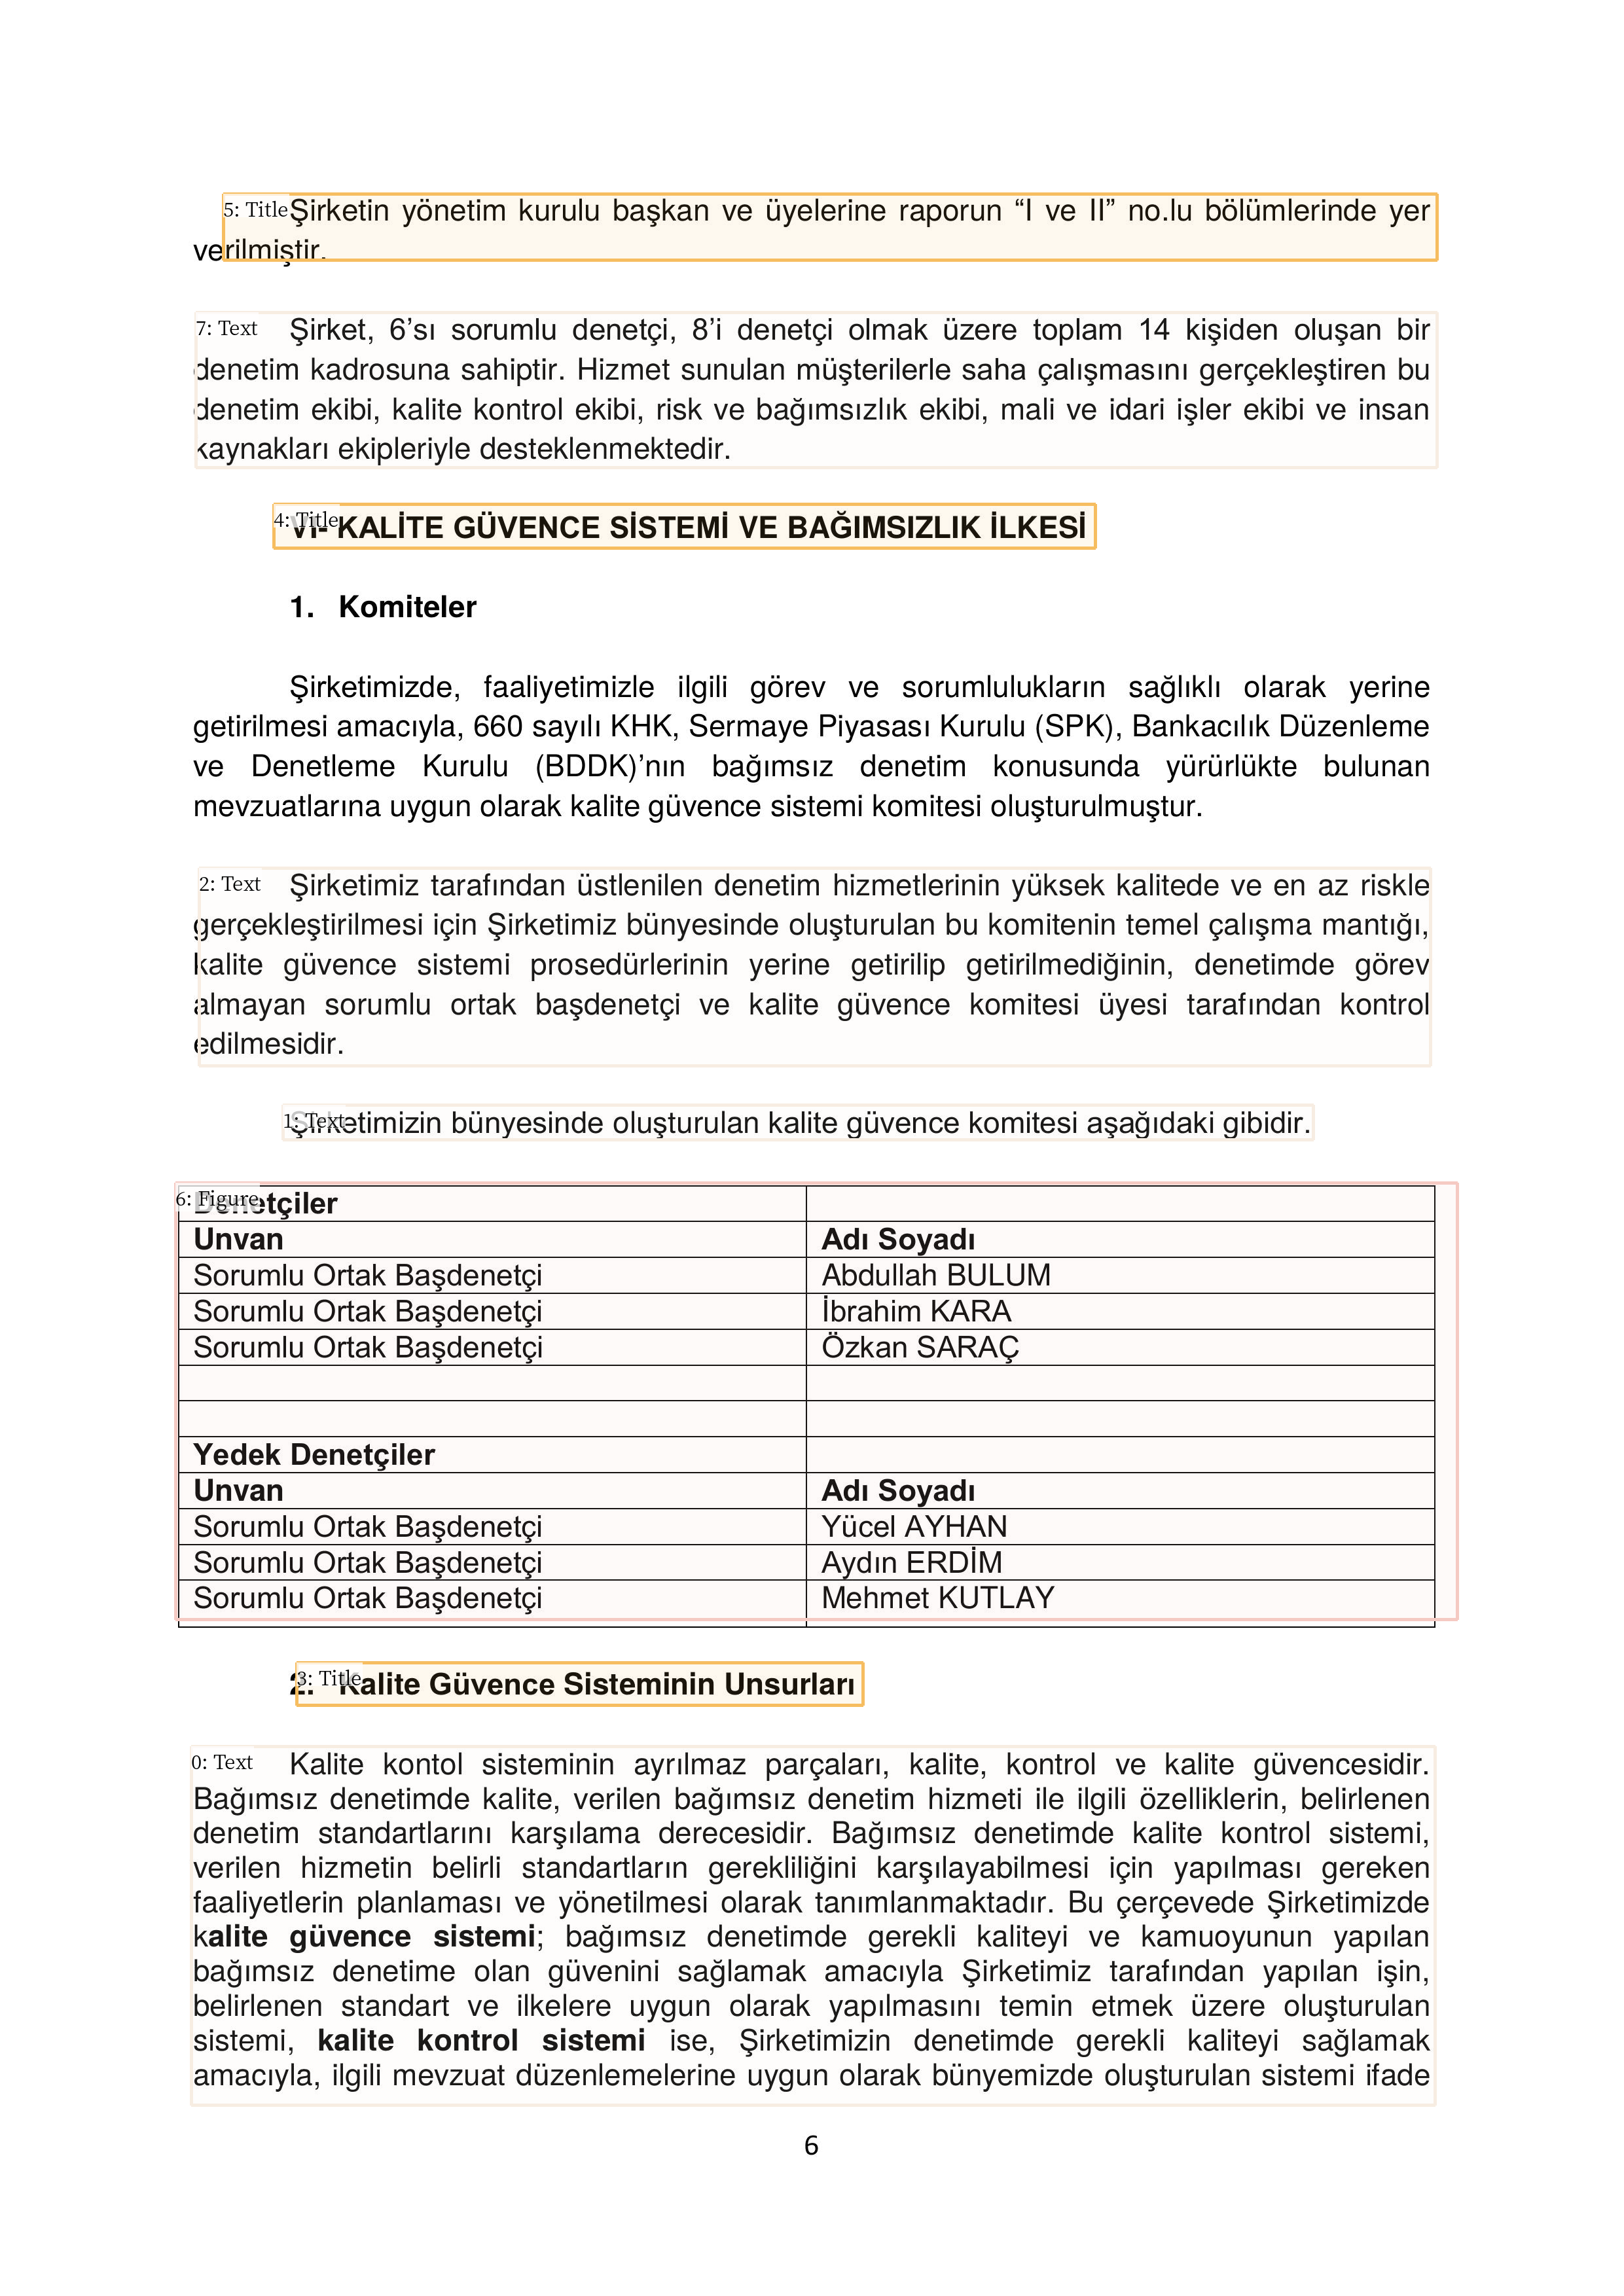

In [8]:
# Show the detected layout of the input image
lp.draw_box(image, layout,
            box_width=5, box_alpha=0.1,
            show_element_id=True,
            show_element_type=True,
            id_font_size=30,
            id_text_background_alpha=0.75)

Check results.

In [9]:
type(layout)

layoutparser.elements.layout.Layout

In [10]:
layout[0]

TextBlock(block=Rectangle(x_1=292.5592346191406, y_1=2668.2080078125, x_2=2192.275146484375, y_2=3216.680419921875), text=None, id=None, type=Text, parent=None, next=None, score=0.997917115688324)

In [11]:
layout

Layout(_blocks=[TextBlock(block=Rectangle(x_1=292.5592346191406, y_1=2668.2080078125, x_2=2192.275146484375, y_2=3216.680419921875), text=None, id=None, type=Text, parent=None, next=None, score=0.997917115688324), TextBlock(block=Rectangle(x_1=432.4721374511719, y_1=1688.5625, x_2=2006.584228515625, y_2=1741.8865966796875), text=None, id=None, type=Text, parent=None, next=None, score=0.9877090454101562), TextBlock(block=Rectangle(x_1=304.2464599609375, y_1=1326.146240234375, x_2=2185.306396484375, y_2=1628.5347900390625), text=None, id=None, type=Text, parent=None, next=None, score=0.9698076248168945), TextBlock(block=Rectangle(x_1=453.3729553222656, y_1=2540.617431640625, x_2=1318.5338134765625, y_2=2605.187744140625), text=None, id=None, type=Title, parent=None, next=None, score=0.969388484954834), TextBlock(block=Rectangle(x_1=418.5671081542969, y_1=770.3986206054688, x_2=1673.325927734375, y_2=837.2766723632812), text=None, id=None, type=Title, parent=None, next=None, score=0.96596

### Use the coordinate system to process the detected layout

Seperate text regions.

In [12]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
title_blocks = lp.Layout([b for b in layout if b.type=='Title'])
list_blocks = lp.Layout([b for b in layout if b.type=='List'])
table_blocks = lp.Layout([b for b in layout if b.type=='Table'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

As there could be text regions detected inside the figure region, we just drop them:

In [13]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

Finally, sort the text regions and assign ids:

In [14]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
# The b.coordinates[1] corresponds to the y coordinate of the region
# sort based on that can simulate the top-to-bottom reading order
right_blocks = lp.Layout([b for b in text_blocks if b not in left_blocks])
right_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

# And finally combine the two lists and add the index
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

Visualize the cleaned text blocks:

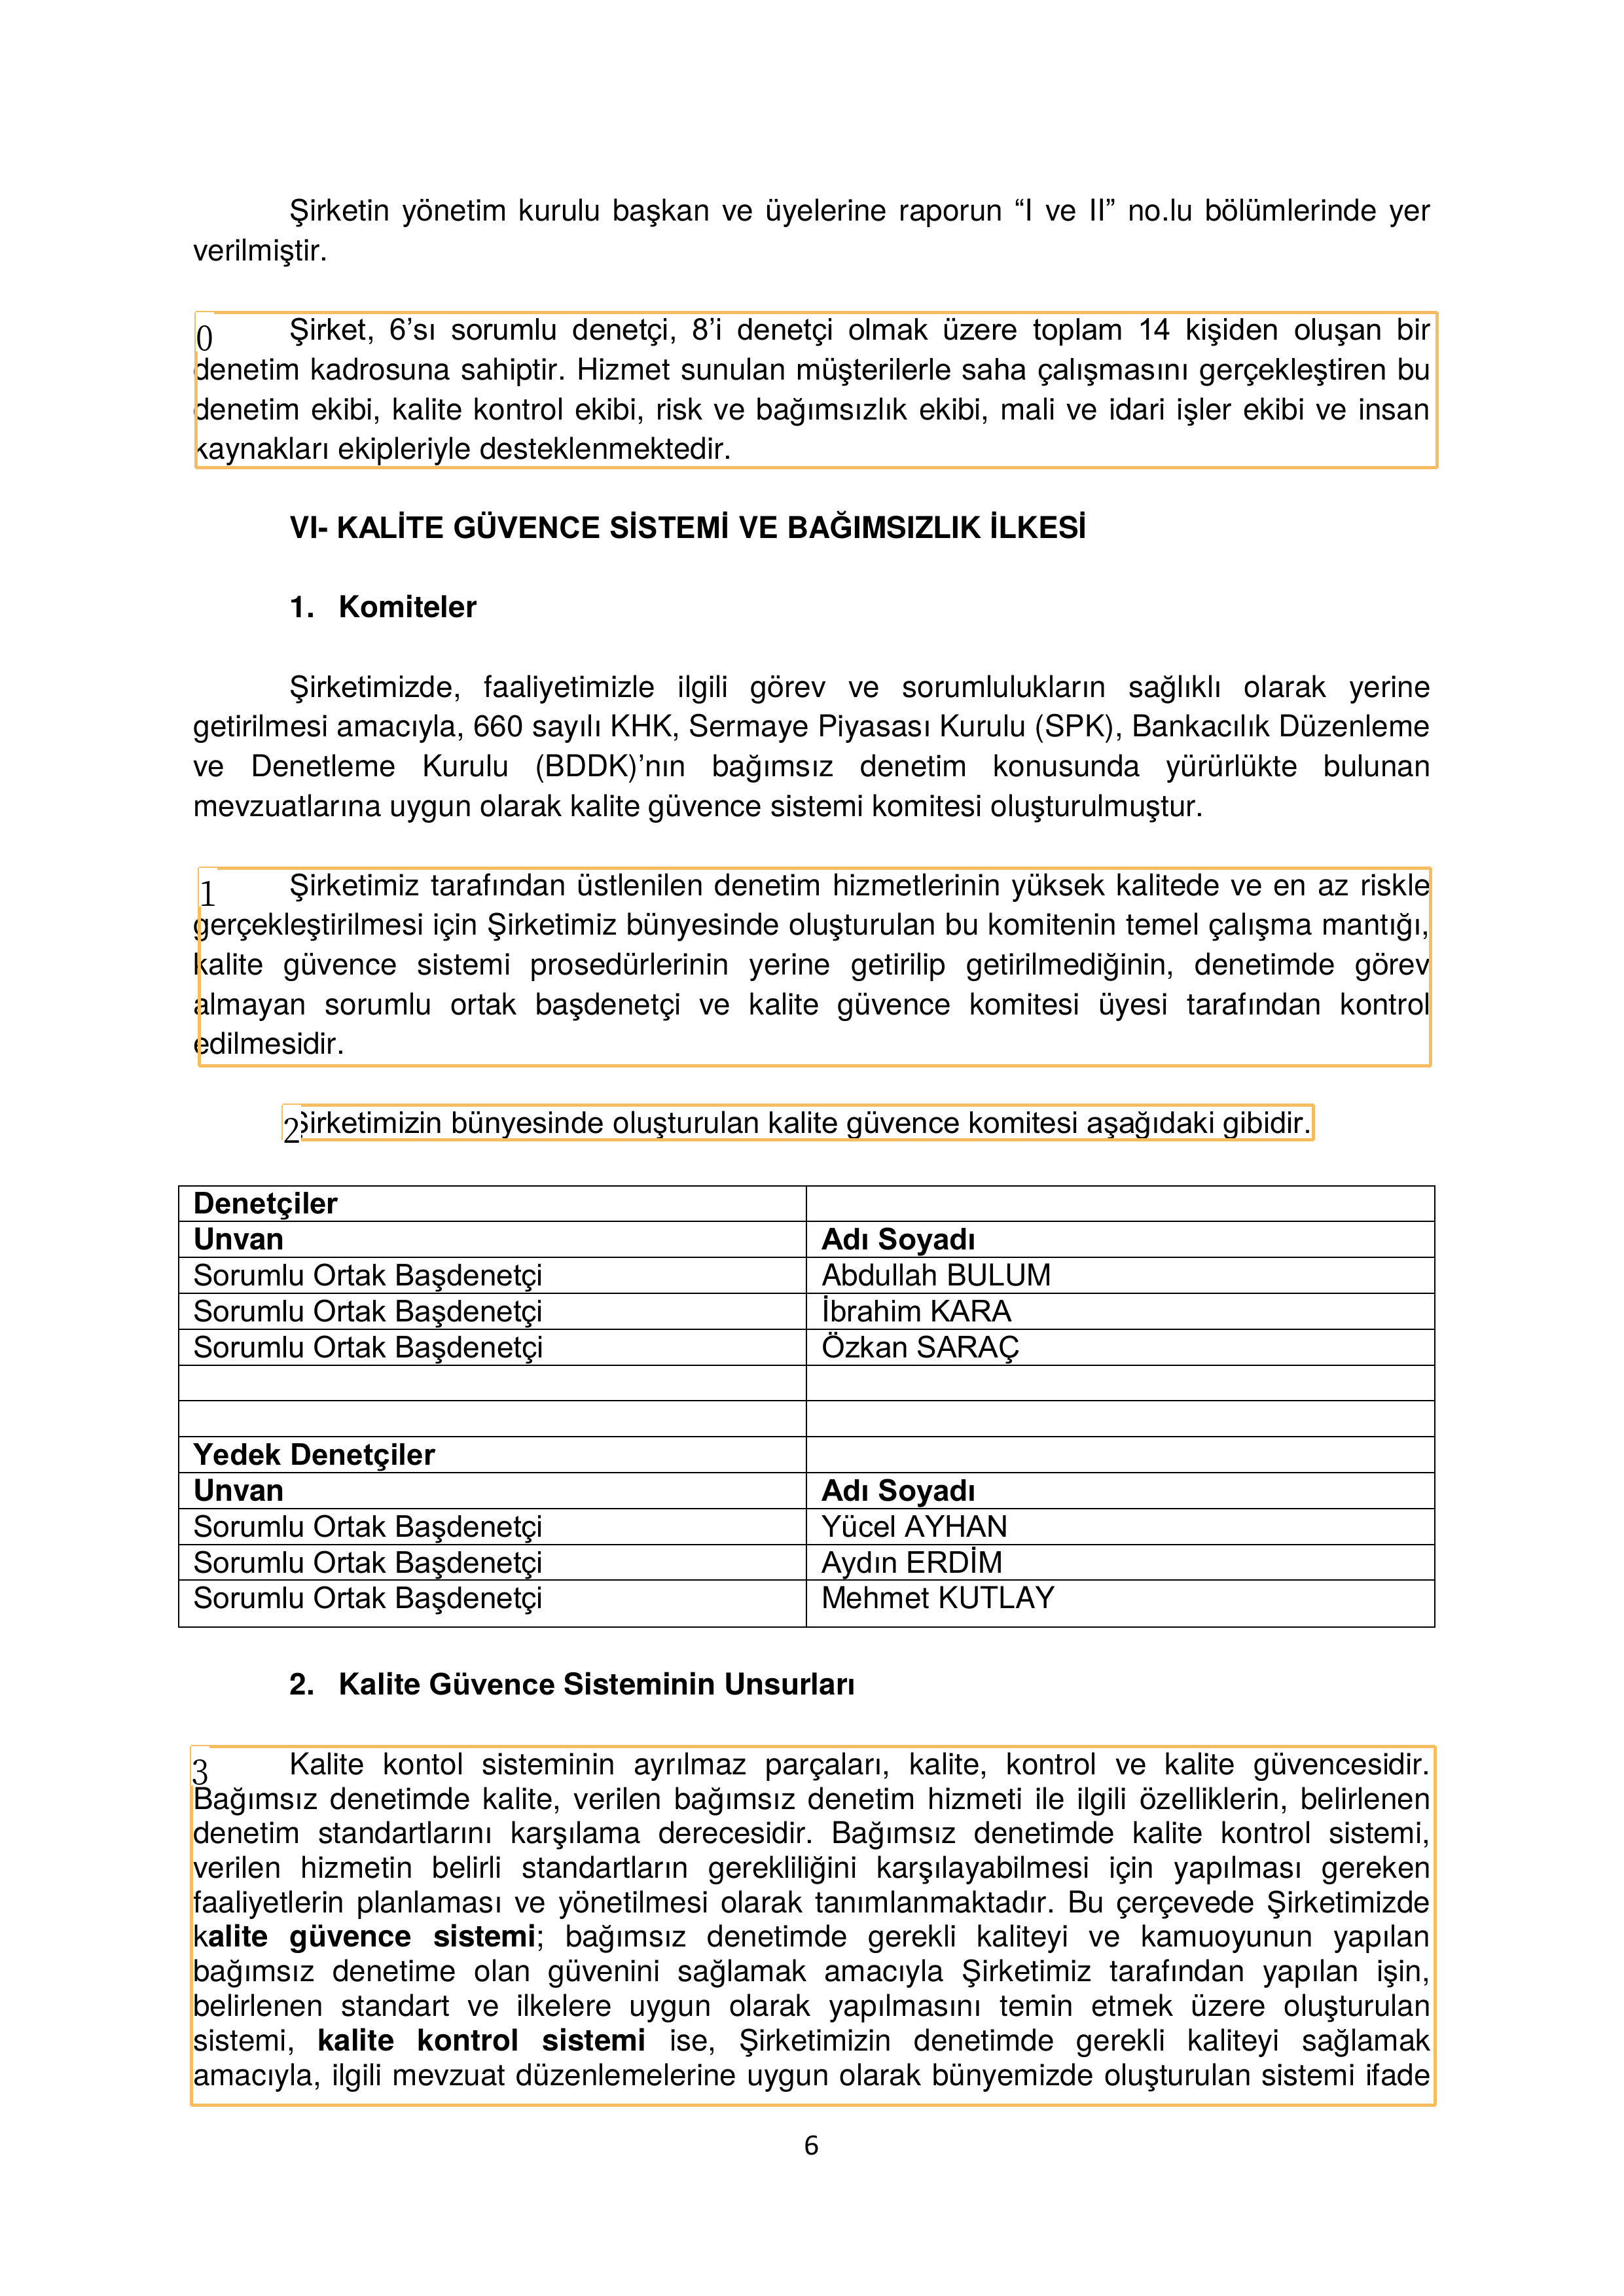

In [15]:
lp.draw_box(image, text_blocks,
            box_width=5,
            show_element_id=True,
            id_font_size=50)

### Fetch the text inside each text region with Tesseract

In [16]:
ocr_agent = lp.TesseractAgent(languages='tur')

In [17]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness

    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [ ]:
# Show ocr result on image
lp.draw_text(image, text_blocks, font_size=40)

In [19]:
# Print
for block in text_blocks:
    print(block, end='\n\n---\n\n')


TextBlock(block=Rectangle(x_1=299.9460754394531, y_1=477.1647033691406, x_2=2195.025146484375, y_2=714.1881713867188), text=Şirket, 6'sı sorumlu denetçi, 8'i denetçi olmak üzere toplam 14 kişiden oluşan bir
denetim kadrosuna sahiptir. Hizmet sunulan müşterilerle saha çalışmasını gerçekleştiren bu
denetim ekibi, kalite kontrol ekibi, risk ve bağımsızlık ekibi, mali ve idari işler ekibi ve insan
kaynakları ekipleriyle desteklenmektedir.
, id=0, type=Text, parent=None, next=None, score=0.9073342084884644)

---

TextBlock(block=Rectangle(x_1=304.2464599609375, y_1=1326.146240234375, x_2=2185.306396484375, y_2=1628.5347900390625), text=Şirketimiz tarafından üstlenilen denetim hizmetlerinin yüksek kalitede ve en az riskle
gerçekleştirilmesi için Şirketimiz bünyesinde oluşturulan bu komitenin temel çalışma mantığı,
kalite güvence sistemi prosedürlerinin yerine getirilip getirilmediğinin, denetimde görev
almayan sorumlu ortak başdenetçi ve kalite güvence komitesi üyesi tarafından kontrol
edil

## Get CSV and Json output from Layout Object

In [20]:
layout.to_dataframe().to_json()

'{"x_1":{"0":292.5592346191,"1":432.4721374512,"2":304.2464599609,"3":453.3729553223,"4":418.5671081543,"5":341.1912536621,"6":268.8042907715,"7":299.9460754395},"y_1":{"0":2668.2080078125,"1":1688.5625,"2":1326.1462402344,"3":2540.6174316406,"4":770.3986206055,"5":296.6893310547,"6":1807.0010986328,"7":477.1647033691},"x_2":{"0":2192.2751464844,"1":2006.5842285156,"2":2185.3063964844,"3":1318.5338134766,"4":1673.3259277344,"5":2195.1594238281,"6":2226.3291015625,"7":2195.0251464844},"y_2":{"0":3216.6804199219,"1":1741.8865966797,"2":1628.5347900391,"3":2605.1877441406,"4":837.2766723633,"5":397.7575683594,"6":2474.5959472656,"7":714.1881713867},"block_type":{"0":"rectangle","1":"rectangle","2":"rectangle","3":"rectangle","4":"rectangle","5":"rectangle","6":"rectangle","7":"rectangle"},"type":{"0":"Text","1":"Text","2":"Text","3":"Title","4":"Title","5":"Title","6":"Figure","7":"Text"},"score":{"0":0.9979171157,"1":0.9877090454,"2":0.9698076248,"3":0.969388485,"4":0.9659680724,"5":0.92

In [21]:
print(text_blocks.to_dataframe().to_csv())
type(text_blocks.to_dataframe())

,x_1,y_1,x_2,y_2,block_type,text,id,type,score
0,299.9460754394531,477.1647033691406,2195.025146484375,714.1881713867188,rectangle,"Şirket, 6'sı sorumlu denetçi, 8'i denetçi olmak üzere toplam 14 kişiden oluşan bir
denetim kadrosuna sahiptir. Hizmet sunulan müşterilerle saha çalışmasını gerçekleştiren bu
denetim ekibi, kalite kontrol ekibi, risk ve bağımsızlık ekibi, mali ve idari işler ekibi ve insan
kaynakları ekipleriyle desteklenmektedir.
",0,Text,0.9073342084884644
1,304.2464599609375,1326.146240234375,2185.306396484375,1628.5347900390625,rectangle,"Şirketimiz tarafından üstlenilen denetim hizmetlerinin yüksek kalitede ve en az riskle
gerçekleştirilmesi için Şirketimiz bünyesinde oluşturulan bu komitenin temel çalışma mantığı,
kalite güvence sistemi prosedürlerinin yerine getirilip getirilmediğinin, denetimde görev
almayan sorumlu ortak başdenetçi ve kalite güvence komitesi üyesi tarafından kontrol
edilmesidir.
",1,Text,0.9698076248168945
2,432.4721374511719,1688.5625,2006.58422

pandas.core.frame.DataFrame

In [22]:
# print(layout.to_dataframe()['type'].value_counts().to_csv().split('\n', 1)[1].replace('\n', ',')[:-1]) output: Text,4,Title,3,Figure,1
print(layout.to_dataframe()['type'].value_counts())

Text      4
Title     3
Figure    1
Name: type, dtype: int64


#Convert All PDF Files to PNG and Parse Layouts

  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


*
A1_2013_PDF.pdf start
*
LAYOUT:
Layout(_blocks=[TextBlock(block=Rectangle(x_1=435.6417541503906, y_1=1517.301025390625, x_2=2171.40185546875, y_2=1591.7142333984375), text=None, id=None, type=Title, parent=None, next=None, score=0.965769350528717), TextBlock(block=Rectangle(x_1=1025.641357421875, y_1=1757.1658935546875, x_2=1615.874267578125, y_2=1826.9476318359375), text=None, id=None, type=Title, parent=None, next=None, score=0.9244203567504883)], page_data={})
OCR:
TextBlock(block=Rectangle(x_1=299.9460754394531, y_1=477.1647033691406, x_2=2195.025146484375, y_2=714.1881713867188), text=Şirket, 6'sı sorumlu denetçi, 8'i denetçi olmak üzere toplam 14 kişiden oluşan bir
denetim kadrosuna sahiptir. Hizmet sunulan müşterilerle saha çalışmasını gerçekleştiren bu
denetim ekibi, kalite kontrol ekibi, risk ve bağımsızlık ekibi, mali ve idari işler ekibi ve insan
kaynakları ekipleriyle desteklenmektedir.
, id=0, type=Text, parent=None, next=None, score=0.9073342084884644)
---
TextBlock(bl

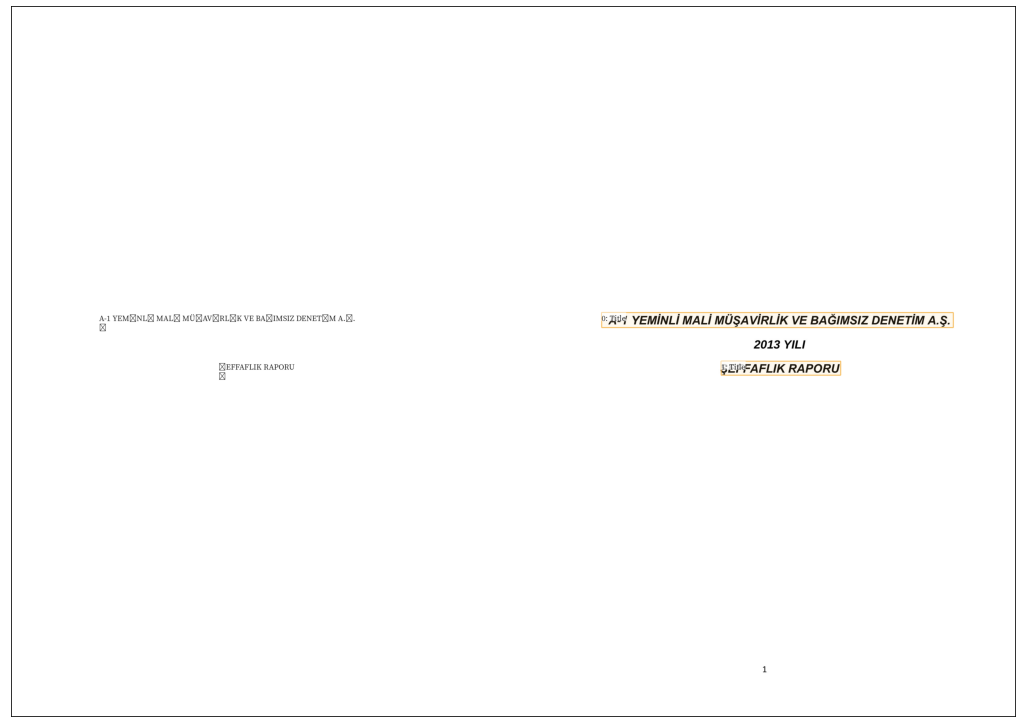

PAGE DATAFRAME 1:
   page_number          x_1          y_1          x_2          y_2 block_type  \
0            1   435.641754  1517.301025  2171.401855  1591.714233  rectangle   
1            1  1025.641357  1757.165894  1615.874268  1826.947632  rectangle   

                                                text   type     score  
0  A-1 YEMİNLİ MALİ MÜŞAVİRLİK VE BAĞIMSIZ DENETİ...  Title  0.965769  
1                                ŞEFFAFLIK RAPORU\n  Title  0.924420  
*
page 1
*
LAYOUT:
Layout(_blocks=[TextBlock(block=Rectangle(x_1=325.84381103515625, y_1=296.9371337890625, x_2=2206.353515625, y_2=408.8392639160156), text=None, id=None, type=Title, parent=None, next=None, score=0.9589950442314148), TextBlock(block=Rectangle(x_1=298.7726135253906, y_1=458.5345764160156, x_2=2199.69384765625, y_2=610.4893188476562), text=None, id=None, type=Title, parent=None, next=None, score=0.7757211327552795), TextBlock(block=Rectangle(x_1=274.120849609375, y_1=847.3802490234375, x_2=2207.008544

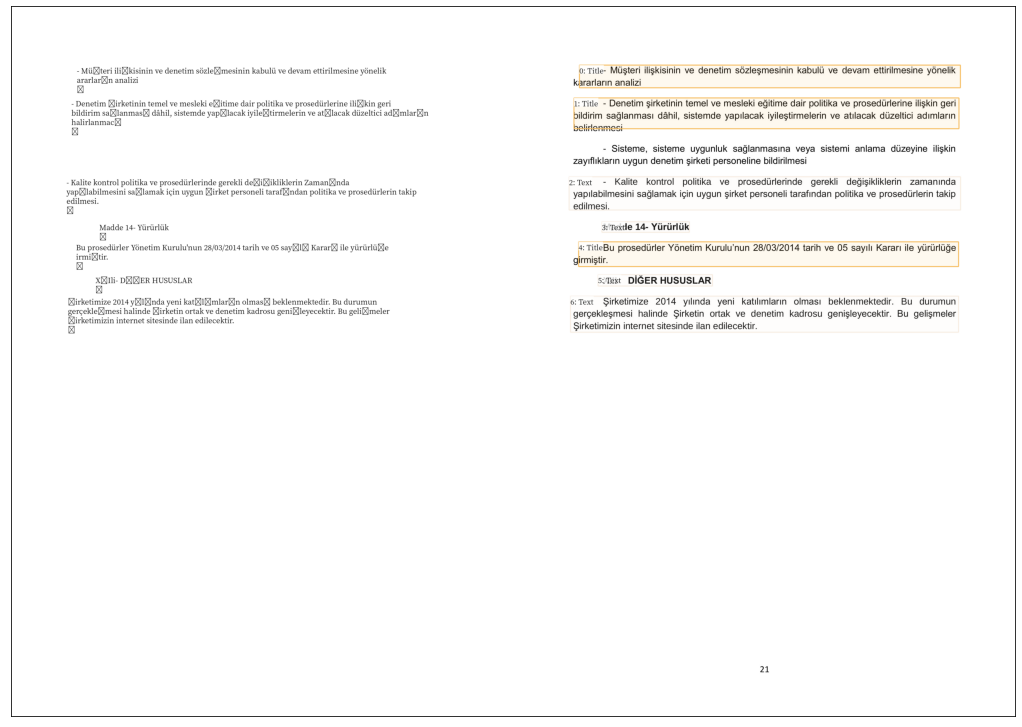

PAGE DATAFRAME 2:
   page_number         x_1          y_1          x_2          y_2 block_type  \
0            2  325.843811   296.937134  2206.353516   408.839264  rectangle   
1            2  298.772614   458.534576  2199.693848   610.489319  rectangle   
2            2  274.120850   847.380249  2207.008545  1011.550049  rectangle   
3            2  436.704681  1069.057373   868.714905  1121.737061  rectangle   
4            2  321.732727  1168.543213  2197.488281  1290.979492  rectangle   
5            2  417.550018  1330.673096   982.805847  1386.890137  rectangle   
6            2  281.411560  1436.027466  2197.450684  1614.833374  rectangle   

                                                text   type     score  
0  - Müşteri ilişkisinin ve denetim sözleşmesinin...  Title  0.958995  
1  - Denetim şirketinin temel ve mesleki eğitime ...  Title  0.775721  
2  - Kalite kontrol politika ve prosedürlerinde g...   Text  0.723457  
3                              Madde 14- Yürürlük\n 

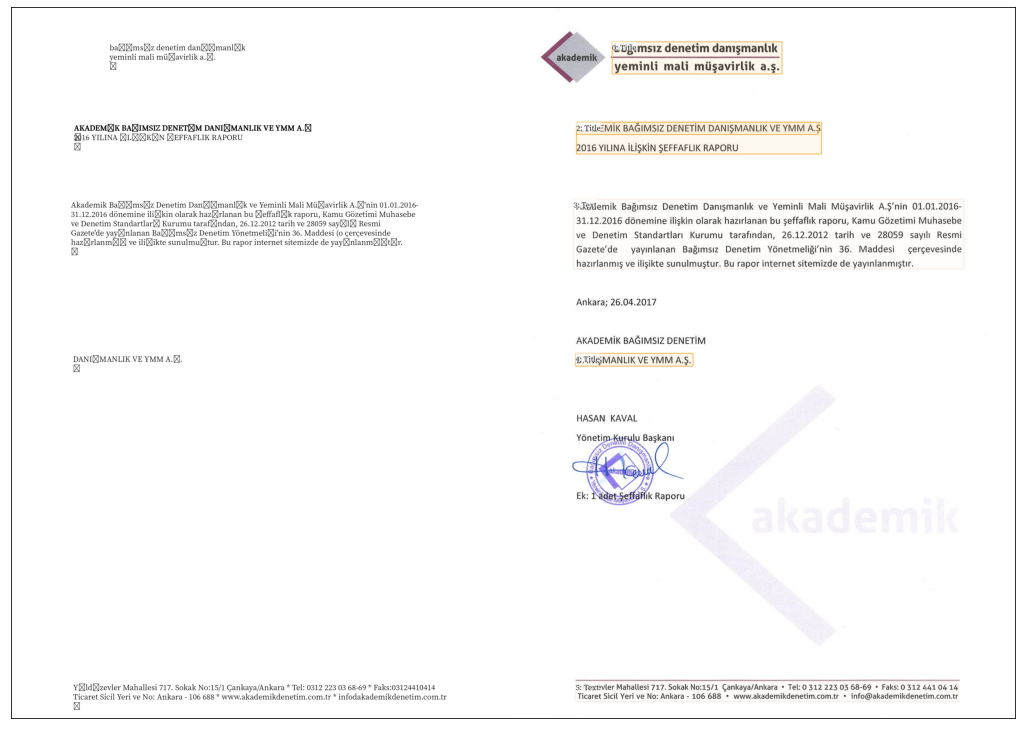

PAGE DATAFRAME 1:
   page_number         x_1          y_1          x_2          y_2 block_type  \
0            1  485.844543   176.829849  1321.053467   334.377258  rectangle   
1            1  311.409363   571.243774  1499.297485   632.823181  rectangle   
2            1  309.620636   572.152344  1515.560181   728.603455  rectangle   
3            1  295.957367   950.698242  2216.926270  1294.584229  rectangle   
4            1  305.047150  1709.544067   883.249390  1772.583252  rectangle   
5            1  306.956085  3325.529053  2189.943115  3423.094727  rectangle   

                                                text   type     score  
0  bağımsız denetim danışmanlık\nyeminli mali müş...  Title  0.962569  
1  AKADEMİK BAĞIMSIZ DENETİM DANIŞMANLIK VE YMM A...  Title  0.783331  
2  AKADEMİK BAĞIMSIZ DENETİM DANIŞMANLIK VE YMM A...  Title  0.891831  
3  Akademik Bağımsız Denetim Danışmanlık ve Yemin...   Text  0.961860  
4                         DANIŞMANLIK VE YMM A.Ş.\n  Title  

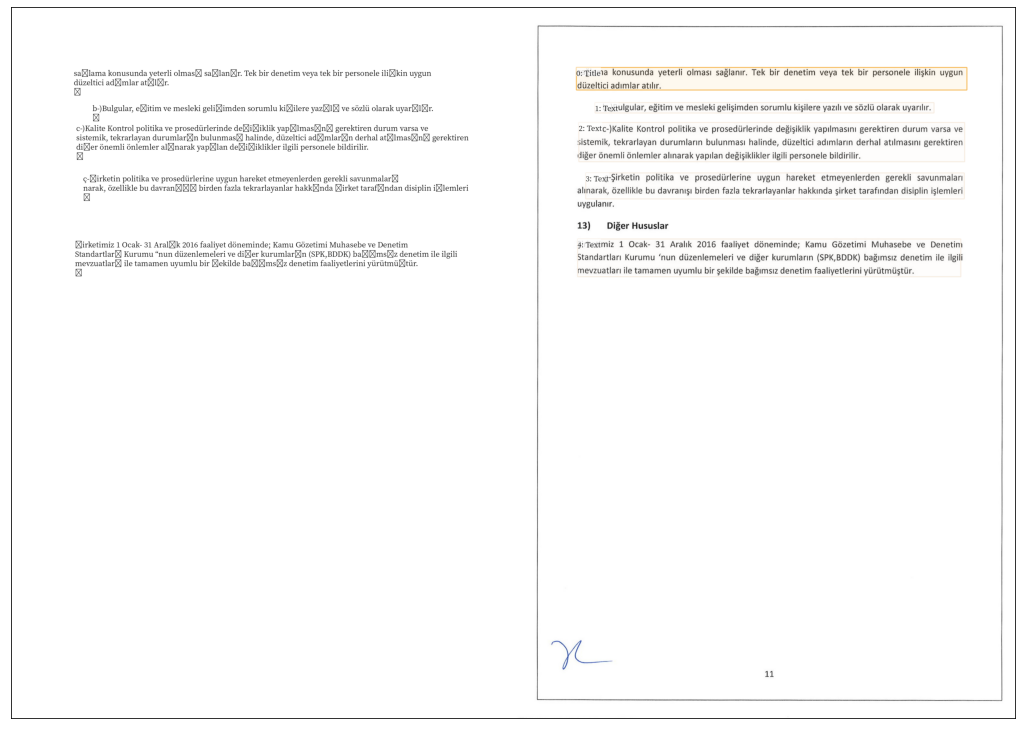

PAGE DATAFRAME 2:
   page_number         x_1          y_1          x_2          y_2 block_type  \
0            2  309.524597   302.859344  2231.055908   413.862701  rectangle   
1            2  401.755310   475.864410  2069.826660   526.715149  rectangle   
2            2  321.134155   573.726929  2220.578857   766.888489  rectangle   
3            2  355.937683   821.256836  2218.688965   949.195801  rectangle   
4            2  315.739563  1146.666992  2201.905029  1332.899658  rectangle   

                                                text   type     score  
0  sağlama konusunda yeterli olması sağlanır. Tek...  Title  0.773481  
1  b-)Bulgular, eğitim ve mesleki gelişimden soru...   Text  0.792347  
2  c-)Kalite Kontrol politika ve prosedürlerinde ...   Text  0.741774  
3  ç-Şirketin politika ve prosedürlerine uygun ha...   Text  0.828085  
4  Şirketimiz 1 Ocak- 31 Aralık 2016 faaliyet dön...   Text  0.959285  
*
page 2
*
FILE DATAFRAME AKADEMIK_2016_SCAN.pdf:
                fil

In [23]:
#!/usr/bin/env python3
import os
import re
import json
import pandas as pd
import pytesseract
from PIL import Image
from pdf2image import convert_from_path
from pathlib import Path
from google.colab import files
import traceback


DEBUG = True
USE_COLAB_DISK = True # else uses drive directory
USE_PDF_IMAGES_AGAIN = False # dont convert pdf to images again, if exists

def debug_print(str):
    if(DEBUG):
        print(str)

# TODO: check builtin pdf2image methods to export directly
def export_images_from_pdf(pdf_path, pdf_name, image_directory):
    pages = convert_from_path(pdf_path, dpi=300)
    image_names = []

    for i, page in enumerate(pages, start=1):
        image_name = f"{pdf_name}_{i:03}.jpg"
        image_names.append(image_name) # will be used while getting images for detection

        if(not Path(f"{image_directory}/{image_name}").is_file()): # file not exists
            page.save(f"{image_directory}/{image_name}", "JPEG")
        else:
            print(f"pass {image_name}")
    return image_names

# get the name of the files and their tags
def get_file_names(directory):
    file_names = []

    for x in os.listdir(directory):
        if x.lower().endswith(".pdf"):
            file_names.append(x)

    file_names = sorted(file_names)
    return file_names

def write_layout(output_file, df): # output_file comes in a+ mode
    csv = df.to_csv()
    if(output_file.read(1) == False): # not empty
        csv.split('\n', 1)[1] # remove header line
    output_file.write(csv) # append

def write_label_data(output_file, file_name, df): # output_file comes in a+ mode
    # if(output_file.read(1) == True): # is empty
    #     output_file.write("Filename, Text, Title, List, Table, Figure\n") # add header

    counts = df['type'].value_counts()
    text_count = counts.get('Text', default='0')
    title_count = counts.get('Title', default='0')
    list_count = counts.get('List', default='0')
    table_count = counts.get('Table', default='0')
    figure_count = counts.get('Figure', default='0')
    output_file.write(f"{file_name}, {text_count}, {title_count}, {list_count}, {table_count}, {figure_count}\n")

    print(f"{file_name}, {text_count}, {title_count}, {list_count}, {table_count}, {figure_count}")


def show_image(image):
    plt.figure(figsize=(18,24))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def sort_two_column_layout(image, layout):
    h, w = image.shape[:2]

    left_interval = lp.Interval(0, w, axis='x').put_on_canvas(image)
    # left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

    left_blocks = layout.filter_by(left_interval, center=True)
    left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
    # The b.coordinates[1] corresponds to the y coordinate of the region
    # sort based on the top-to-bottom reading order
    right_blocks = lp.Layout([b for b in layout if b not in left_blocks])
    right_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

    # And finally combine the two lists and add the index
    return lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

def sort_one_column_layout(image, layout):
    # The b.coordinates[1] corresponds to the y coordinate of the region
    # sort based on the y axis reading order
    layout.sort(key = lambda b:b.coordinates[1], inplace=True) # Sort by top y coordinate

    return layout


def main():
    # Arrange directories for io
    pdf_directory = f"/content/drive/MyDrive/seffaflik-raporlari" # source pdf files
    file_names = get_file_names(pdf_directory) # pdf file names to be parsed

    if(USE_COLAB_DISK):
      main_directory = "/content/seffaflik-raporlari"
    else:
      main_directory = pdf_directory

    data_directory = f"{main_directory}/out" # to store csv data
    image_directory = f"{main_directory}/images" # to store page images
    Path(data_directory).mkdir(parents=True, exist_ok=True)
    Path(image_directory).mkdir(parents=True, exist_ok=True)

    # Load the deep layout model from the layoutparser API
    model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
                                    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.7],  # original value is 0.8
                                    label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
    # model = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config',
    #                             extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
    #                             label_map={1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"})
    ocr_agent = lp.TesseractAgent(languages='tur')


    # moved to main loop
    # layouts_file = open(f"{data_directory}/layouts.csv", "a+") # will include All data of layouts
    labels_file = open(f"{data_directory}/labels.csv", "a+") # will include Occurence counts of labels
    labels_file.write("Filename, Text, Title, List, Table, Figure\n") # add header

    for file_name in file_names:  # Iterate all files from input directory
        print(f"*\n{file_name} start\n*")
        try:
            layouts_file = open(f"{data_directory}/layout.csv", "a+") # will include All data of page layouts
            labels_file = open(f"{data_directory}/labels.csv", "a+") # will include Occurence counts of labels

            file_df = pd.DataFrame() # layouts of all pages in the file
            image_names = []
            image_names = export_images_from_pdf(f"{pdf_directory}/{file_name}", file_name, image_directory) # Convert pdf files to images

            for i, image_name in enumerate(image_names, start=1):  # Iterate all pages of a file
                image_path = f"{image_directory}/{image_name}"
                layout_image_path = f"{image_directory}/l_{image_name}"
                # print(image_path)

                # --------------------- Layout Parsing ------------------- #
                # Get Image
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert the image from BGR (cv2 default loading style) to RGB

                # Delete Image from Storage
                if(not USE_PDF_IMAGES_AGAIN):
                    os.remove(image_path)

                # Display input image
                # if(DEBUG):
                #   show_image(image)

                # Detect the layout of the input image
                layout = model.detect(image)
                layout = sort_one_column_layout(image, layout) # Sort blocks
                debug_print(f"LAYOUT:\n{layout}") # layout.sort()

                # Perform OCR
                for block in layout:
                  segment = block.pad(left=5, right=5, top=5, bottom=5).crop_image(image) # add padding in each image segment can help improve robustness: block.pad(left=5, right=5, top=5, bottom=5).crop_image(image)
                  block.text = ocr_agent.detect(segment)

                # Print OCR result
                if(DEBUG):
                  print("OCR:")
                  for block in text_blocks:
                    print(block, end='\n---\n')
                  print('\n\n#########\n\n')

                # Show the detected layout of the input image
                layout_image = lp.draw_box(image, layout,
                                            box_width=5, box_alpha=0.1,
                                            show_element_id=True,
                                            show_element_type=True,
                                            id_font_size=36,
                                            id_text_background_alpha=0.8)
                # Add ocr results to the side of layout image
                layout_image = lp.draw_text(layout_image, layout, font_size=36).convert("RGB")

                if(DEBUG):
                  show_image(layout_image)

                # Save new images with layout drawn
                layout_image.save(layout_image_path)

                # if(!USE_COLAB_DISK):
                #   files.download(layout_image_path) # Download to local
                #   os.remove(layout_image_path) # Free up colab storage

                # Append page layout to file
                page_df = layout.to_dataframe()
                page_df.insert(0, "page_number", i)
                file_df = file_df.append(page_df)

                debug_print(f"PAGE DATAFRAME {i}:\n{page_df}")
                print(f'*\npage {i}\n*')

            # Create file name column
            file_df.insert(0, "file_name", file_name)
            debug_print(f"FILE DATAFRAME {file_name}:\n{file_df}")

            # Append label data to file
            write_label_data(labels_file, file_name, file_df)

            # Append layout to file
            write_layout(layouts_file, file_df)

            layouts_file.close()
            labels_file.close()
            print(f"*\n{file_name} end\n*")

        except Exception as e:
            print(f"An error occured on {file_name}, Error message = {e}")
            traceback.print_exc()

    # moved to main loop
    # layouts_file.close()
    # labels_file.close()
    print("done")


if __name__ == "__main__":
    main()

# Download output

In [24]:
# !zip -r /content/seffaflik-raporlari-images.zip /content/seffaflik-raporlari-images/

In [25]:
# !zip -r /content/seffaflik-raporlari-out.zip /content/seffaflik-raporlari-out/

In [26]:
# from google.colab import files
# files.download("/content/seffaflik-raporlari-images.zip")
# files.download("/content/seffaflik-raporlari-out.zip")

## Move outputs from Colab Disk to Google Drive

In [27]:
# Just drag and drop folders into /content/MyDrive/ or
# !mv /content/seffaflik-raporlari-images/ /content/drive/MyDrive/seffaflik-raporlari-images/